In [1]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
from tensorflow.keras.initializers import TruncatedNormal
from tqdm import tqdm
from time import time
import pandas as pd
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import sys

In [2]:
# base_folder = 'F:\\Projects\\train\\episerver\\data\\rs\\'
base_folder = 'E:\\Projects\\Train\\episerver\\data\\rs\\'
model_folder = 'E:\\Projects\\Train\\episerver\\model\\rs\\'

In [3]:
class RSModel(Model):

    def __init__(self, args):
        super(RSModel, self).__init__()
        self.embedding_size = args['embedding_size']
        self.keyword_embedding_size = args['keyword_embedding_size']
        self.alpha = args['alpha']
        self.beta = args['beta']
        self.gamma = args['gamma']
        self.num_items = args['num_items']
        self.num_users = args['num_users']
        self.num_keywords = args['num_keywords']
        self.item_keywords = tf.constant(args['item_keywords'], dtype=tf.int32)
        self.keyword_embedding = tf.keras.layers.Embedding(input_dim=self.num_keywords + 1, output_dim=self.keyword_embedding_size,
                                                           embeddings_initializer=TruncatedNormal(mean=0., stddev=0.1),
                                                           mask_zero=True,
                                                           embeddings_regularizer=tf.keras.regularizers.L2(self.alpha))
        self.user_embedding = tf.keras.layers.Embedding(input_dim=self.num_users + 1, output_dim=self.embedding_size,
                                                        embeddings_initializer=TruncatedNormal(mean=0., stddev=0.1),
                                                        embeddings_regularizer=tf.keras.regularizers.L2(self.beta))
        self.item_embedding = tf.keras.layers.Embedding(input_dim=self.num_items, output_dim=self.embedding_size,
                                                        embeddings_initializer=TruncatedNormal(mean=0., stddev=0.1),
                                                        embeddings_regularizer=tf.keras.regularizers.L2(self.beta))
        self.bias_u = tf.keras.layers.Embedding(input_dim=self.num_users + 1, output_dim=1,
                                                embeddings_initializer=TruncatedNormal(mean=0., stddev=0.1),
                                                embeddings_regularizer=tf.keras.regularizers.L2(self.gamma))
        self.bias_i = tf.keras.layers.Embedding(input_dim=self.num_items, output_dim=1,
                                                embeddings_initializer=TruncatedNormal(mean=0., stddev=0.1),
                                                embeddings_regularizer=tf.keras.regularizers.L2(self.gamma))
        self.mlp_dense = tf.keras.layers.Dense(units=1)

    def call(self, user_ids, item_ids):
        user_bias = self.bias_u(user_ids)
        item_bias = self.bias_i(item_ids)
        # matrix factorization
        users_embedding = self.user_embedding(user_ids)
        items_embedding = self.item_embedding(item_ids)
        mf = tf.math.multiply(users_embedding, items_embedding)
        # mlp
        item_keyword = tf.nn.embedding_lookup(self.item_keywords, item_ids)
        item_keyword_embedding = self.keyword_embedding(item_keyword)
        item_encode = tf.reduce_sum(item_keyword_embedding, axis=1)
        item_encode = self.mlp_dense(item_encode)
        # rating score
        r = tf.squeeze(user_bias) + tf.squeeze(item_bias) + tf.reduce_sum(mf, axis=1) + tf.reduce_sum(item_encode, axis=1)
        
#         r = tf.squeeze(user_bias) + tf.squeeze(item_bias) + tf.reduce_sum(mf, axis=1)
        return r

    def loss_fn_rmse(self, predictions, labels):
        loss = tf.reduce_sum(tf.math.square(predictions - labels))
        loss += tf.reduce_sum(self.keyword_embedding.losses)
        loss += tf.reduce_sum(rsmodel.user_embedding.losses) + tf.reduce_sum(rsmodel.item_embedding.losses)
#         loss += tf.reduce_sum(self.bias_u.losses) + tf.reduce_sum(self.bias_i.losses)
        return loss

def get_val_rmse(rs_model, val_dataset):
    all_ratings = []
    all_predictions = []
    for i in tqdm(range(val_dataset.num_batch)):
        user_ids, item_ids, ratings = val_dataset.get_batch(i)
        predictions = rs_model(user_ids, item_ids)
        all_predictions.append(predictions.numpy())
        all_ratings.append(ratings)
    val_predictions = np.concatenate(all_predictions, axis=0)
    val_ratings = np.concatenate(all_ratings, axis=0)
    return np.sqrt(np.mean((val_predictions - val_ratings) ** 2))

In [4]:
class DataSet:

    def __init__(self, ratings, batch_size=128):
        self.ratings = ratings
        self.batch_size = batch_size
        self.num_batch = self.ratings.shape[0] // self.batch_size

    def shuffle(self):
        np.random.shuffle(self.ratings)

    def get_batch(self, i):
        user_ids = self.ratings[i * self.batch_size: (i + 1) * self.batch_size, 0]
        item_ids = self.ratings[i * self.batch_size: (i + 1) * self.batch_size, 1]
        rates = self.ratings[i * self.batch_size: (i + 1) * self.batch_size, 2]
        return (np.array(user_ids, dtype=np.int32),
                np.array(item_ids, dtype=np.int32),
                np.array(rates, dtype=np.float32))

### load data

In [5]:
train = pickle.load(open(model_folder + 'train.pkl', 'rb'))
val = pickle.load(open(model_folder + 'val.pkl', 'rb'))
test = pickle.load(open(model_folder + 'test.pkl', 'rb'))

movie_id_idx_map = pickle.load(open(model_folder + 'movie_id_idx_map.pkl', 'rb'))
idx_movie_id_map = pickle.load(open(model_folder + 'idx_movie_id_map.pkl', 'rb'))
meta_data = pickle.load(open(model_folder + 'meta_data.pkl', 'rb'))

item_keywords = pickle.load(open(model_folder + 'item_keywords.pkl', 'rb'))

In [6]:
args = dict()
args['embedding_size'] = 64
args['keyword_embedding_size'] = 64
args['alpha'] = 0.005
args['beta'] = 0.005
args['gamma'] = 0.000
args['num_items'] = meta_data['num_items']
args['num_users'] = meta_data['num_users']
args['num_keywords'] = meta_data['num_keywords']
args['item_keywords'] = item_keywords

In [7]:
rec_model = RSModel(args)

epoch_step = tf.Variable(0, dtype=tf.int32)
ckpt = tf.train.Checkpoint(rec_model=rec_model, epoch_step=epoch_step)
manager = tf.train.CheckpointManager(checkpoint=ckpt, directory='./rsmodel_ckpt', max_to_keep=3)
print('load pretrained model at: ' + manager.latest_checkpoint)
ckpt.restore(manager.latest_checkpoint)

load pretrained model at: ./rsmodel_ckpt\ckpt-5


In [8]:
test_dataset = DataSet(test[['userId', 'itemId', 'rating']].values, batch_size=1024)
get_val_rmse(rec_model, test_dataset)

100%|█████████████████████████████████████████████████████████████████████████████| 1270/1270 [00:03<00:00, 329.74it/s]


0.8765559

In [9]:
top_n = 100
item_ids = np.array(range(meta_data['num_items']))

In [10]:
users_embedding = rec_model.user_embedding.weights[0].numpy()
items_encode = rec_model.item_embedding.weights[0].numpy()
items_bias = np.squeeze(rec_model.bias_i.weights[0].numpy())
users_bias = rec_model.bias_u.weights[0].numpy()

In [11]:
item_keyword = tf.nn.embedding_lookup(rec_model.item_keywords, item_ids)
item_keyword_embedding = rec_model.keyword_embedding(item_keyword)
item_keyword_encode = tf.reduce_sum(item_keyword_embedding, axis=1)
item_keyword_encode = rec_model.mlp_dense(item_keyword_encode)
item_keyword_encode = np.squeeze(item_keyword_encode.numpy())

In [12]:
predict_user_dict = dict()
# list_predict_users = []
for user_id in tqdm(range(1, meta_data['num_users'])):
    user_embedded = users_embedding[user_id]
    user_bias = users_bias[user_id]
    predicts = np.squeeze(np.matmul(user_embedded.reshape(1, -1), items_encode.T)) + items_bias + user_bias + item_keyword_encode
    best = np.argpartition(predicts, -top_n)[-top_n:]
#     predict_user_dict[user_id] = sorted(zip(best, predicts[best]), key=lambda x: -x[1])
    predict_user_dict[user_id] = best.astype(np.int32)
#     list_predict_users.append(best.astype(np.int32))

100%|█████████████████████████████████████████████████████████████████████████| 270895/270895 [09:34<00:00, 471.84it/s]


In [13]:
predict_user_dict.__len__()

270895

In [14]:
pickle.dump(predict_user_dict, open(model_folder + 'predict_user_dict.pkl', 'wb'))

### GUI prediction

In [15]:
user_id = 1000

In [16]:
ratings = pd.read_csv(base_folder + 'ratings.csv')
movies_metadata = pd.read_csv(base_folder + 'movies_metadata.csv')

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
movies_metadata['title'].isna().sum()

6

In [18]:
movies_metadata.shape

(45466, 24)

In [19]:
movies_metadata = movies_metadata[['id', 'release_date', 'title']].copy()

In [20]:
movies_metadata['id'] = movies_metadata['id'].apply(lambda x: -1 if str(x).__contains__('-') else int(x))
movies_metadata['id'] = movies_metadata['id'].astype(np.int64)

In [21]:
movies_metadata[movies_metadata['id'] > 0]

,id,release_date,title
0,862,1995-10-30,Toy Story
1,8844,1995-12-15,Jumanji
2,15602,1995-12-22,Grumpier Old Men
3,31357,1995-12-22,Waiting to Exhale
4,11862,1995-02-10,Father of the Bride Part II
...,...,...,...
45461,439050,NaN,Subdue
45462,111109,2011-11-17,Century of Birthing
45463,67758,2003-08-01,Betrayal
45464,227506,1917-10-21,Satan Triumphant


In [22]:
set(ratings['movieId'].unique()).intersection(set(movies_metadata['id'])).__len__()

7565

In [23]:
ratings = ratings.drop(columns='timestamp')
ratings = ratings.merge(movies_metadata, how='left', left_on='movieId', right_on='id')
ratings = ratings.drop(columns='id')

In [24]:
user_id = 10002

In [25]:
rec_item_idx = predict_user_dict[user_id]
rec_movie_ids = []
for item_idx in rec_item_idx:
    rec_movie_ids.append(idx_movie_id_map[item_idx])

In [52]:
ratings[ratings['userId'] == user_id][['rating', 'release_date', 'title']].values

array([[3.5, '1988-10-21', 'Ariel'],
       [1.5, '1986-10-16', 'Shadows in Paradise'],
       [2.0, '1927-01-10', 'Metropolis'],
       [2.5, '2003-10-10', 'Kill Bill: Vol. 1'],
       [4.5, nan, nan],
       [2.0, nan, nan],
       [4.0, nan, nan],
       [1.5, '1998-07-01', 'Armageddon'],
       [2.0, '1998-08-20', 'Run Lola Run'],
       [3.0, '1994-05-27', 'Three Colors: Red'],
       [1.5, '2003-12-01',
        'The Lord of the Rings: The Return of the King'],
       [2.5, '1996-05-13', 'Breaking the Waves'],
       [3.0, '1982-12-07', '48 Hrs.'],
       [2.0, '2003-08-31', 'Lost in Translation'],
       [1.5, '1989-06-09', 'Star Trek V: The Final Frontier'],
       [1.0, '1954-12-23', '20,000 Leagues Under the Sea'],
       [1.5, '1994-11-17', 'Star Trek: Generations'],
       [1.5, '1990-05-25', 'Back to the Future Part III'],
       [2.5, '1942-03-05', 'To Be or Not to Be'],
       [2.0, nan, nan],
       [3.0, '1974-03-05', 'Ali: Fear Eats the Soul'],
       [2.0, '1984-10-26

In [26]:
ratings[ratings['userId'] == user_id].head(20)

,userId,movieId,rating,release_date,title
978570,10002,2,3.5,1988-10-21,Ariel
978571,10002,3,1.5,1986-10-16,Shadows in Paradise
978572,10002,19,2.0,1927-01-10,Metropolis
978573,10002,24,2.5,2003-10-10,Kill Bill: Vol. 1
978574,10002,32,4.5,NaN,NaN
978575,10002,44,2.0,NaN,NaN
978576,10002,47,4.0,NaN,NaN
978577,10002,95,1.5,1998-07-01,Armageddon
978578,10002,104,2.0,1998-08-20,Run Lola Run
978579,10002,110,3.0,1994-05-27,Three Colors: Red


In [54]:
movies_metadata[movies_metadata['id'].isin(rec_movie_ids)].head(20)

,id,release_date,title
151,649,1967-05-24,Belle de Jour
459,2019,1993-08-20,Hard Target
534,858,1993-06-24,Sleepless in Seattle
700,922,1995-12-23,Dead Man
1162,947,1962-12-10,Lawrence of Arabia
1242,665,1959-12-26,Ben-Hur
2649,912,1968-06-19,The Thomas Crown Affair
2827,2731,1992-04-15,Indochine
3058,926,1999-12-23,Galaxy Quest
3708,2360,2000-01-24,Saving Grace


In [29]:
movie_agg = ratings.groupby(by='movieId').agg({
    'userId': 'count',
    'rating': 'mean'
})
movie_agg.columns = ['num_ratings', 'mean_rating']
movie_agg = movie_agg.reset_indext_index()

In [32]:
import seaborn as sns

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


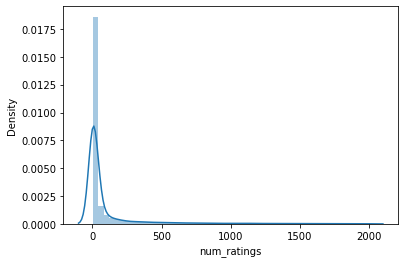

In [36]:
sns.distplot(movie_agg[movie_agg['num_ratings'] < 2000]['num_ratings'])

In [42]:
movie_agg[movie_agg['num_ratings'] > 1000].shape

(3745, 3)

In [43]:
movie_agg = movie_agg[movie_agg['num_ratings'] > 1000]
movie_agg = movie_agg.sort_values(by='mean_rating', ascending=False)
top_movies_id = list(movie_agg[:200]['movieId'])

In [47]:
top_movies_id

[318,
 858,
 50,
 527,
 1221,
 2019,
 904,
 1203,
 2959,
 1193,
 912,
 750,
 1212,
 908,
 1178,
 3435,
 5618,
 922,
 44555,
 6016,
 58559,
 3030,
 1213,
 926,
 296,
 930,
 2324,
 1284,
 1260,
 79132,
 1252,
 1207,
 1248,
 4226,
 1136,
 2571,
 593,
 950,
 5971,
 1234,
 1217,
 2329,
 1196,
 913,
 905,
 3134,
 1148,
 1198,
 1945,
 2203,
 260,
 1147,
 1197,
 2858,
 5291,
 4973,
 1254,
 86504,
 2186,
 2920,
 1172,
 541,
 92259,
 903,
 112552,
 1201,
 48516,
 3307,
 6669,
 1204,
 1280,
 3089,
 3000,
 745,
 3022,
 898,
 1949,
 116897,
 7153,
 2731,
 2351,
 1131,
 1208,
 1209,
 1233,
 608,
 7327,
 1262,
 4993,
 3429,
 2905,
 951,
 2859,
 3462,
 98491,
 2935,
 923,
 2360,
 1224,
 1189,
 1267,
 5690,
 1089,
 111,
 1237,
 1256,
 109487,
 5147,
 3468,
 326,
 3196,
 1939,
 1250,
 7156,
 2357,
 1276,
 293,
 5952,
 48780,
 2066,
 7361,
 142488,
 928,
 5008,
 3819,
 678,
 31658,
 1132,
 942,
 7099,
 47,
 1704,
 3677,
 1361,
 27773,
 1617,
 969,
 3469,
 1219,
 2726,
 5782,
 1225,
 800,
 2208,
 4011,
 3

In [27]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'release_date', 'title'], dtype='object')